In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
# from rascal.atlas import Atlas

from lvmdrp.utils.examples import get_frames_metadata
from lvmdrp.core import rss

from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

/home/mejia/Downloads/home/mejia/.local/bin/miniconda3/envs/lvmdrp/lib/python3.8/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = os.path.join("data")
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.{ext}")

# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "sim_2d"))
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["imagetyp", "spec", "camera", "expnum", "exptime"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/sim_2d/frames_table.pkl'


[WARNING]: divide by zero encountered in divide (RuntimeWarning)


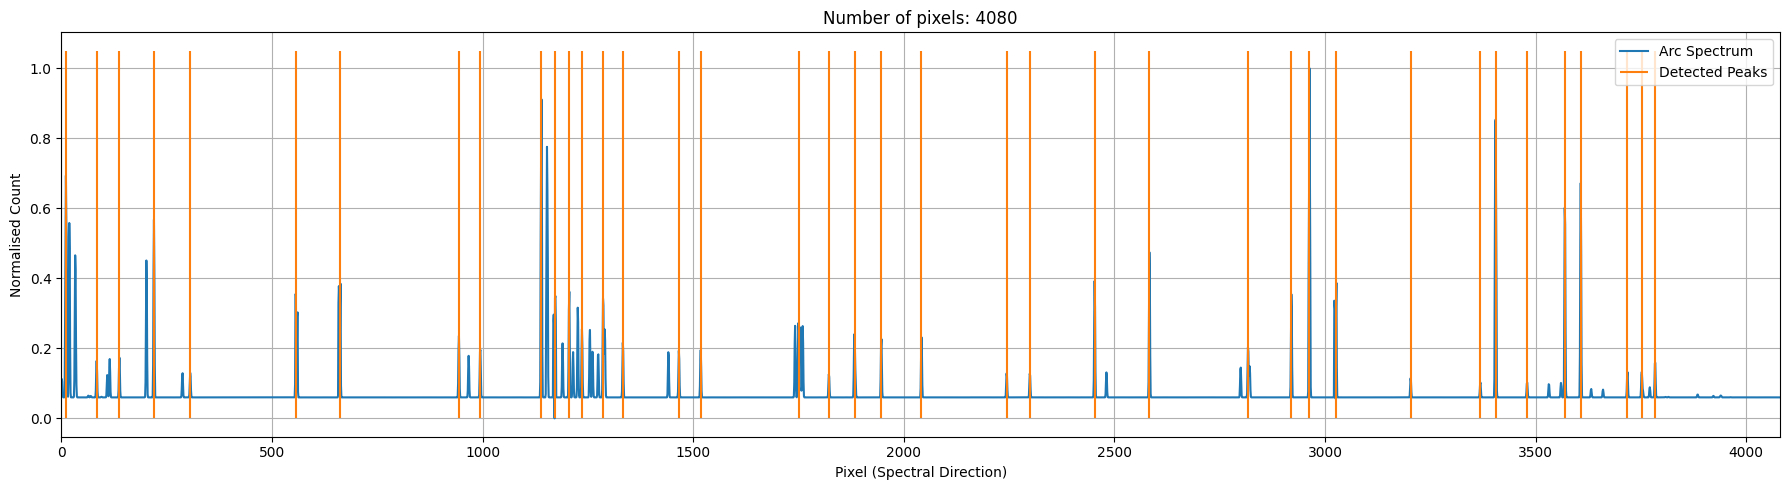

  0%|          | 0/5000 [00:00<?, ?it/s]

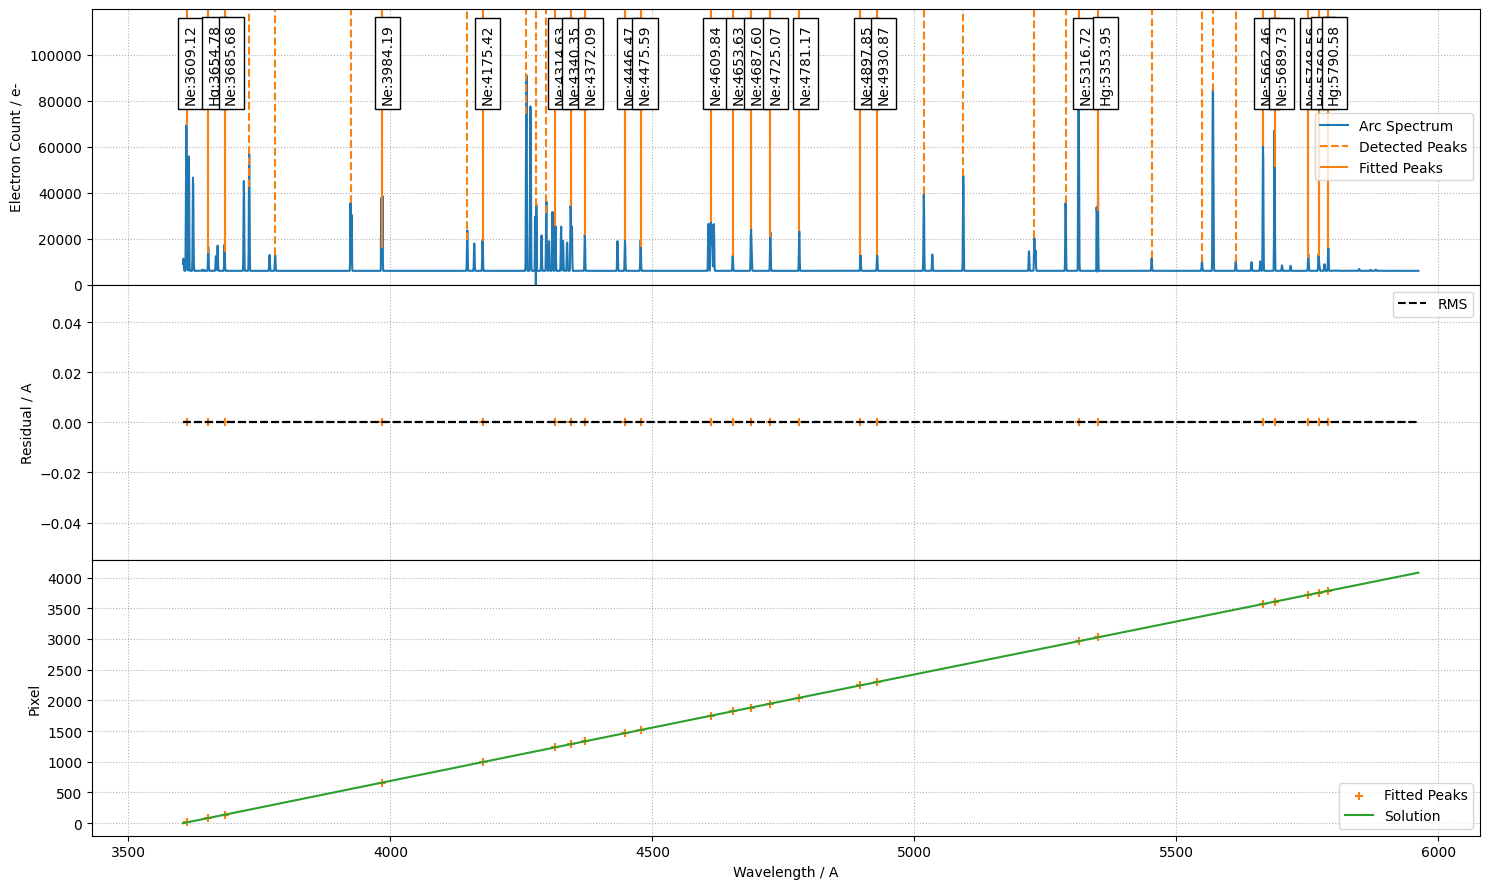

RMS: 2.0256229679554787
Stdev error: 1.1300304962324583 A
Peaks utilisation rate: 61.53846153846154%
Start measuring arc lines...
[WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)


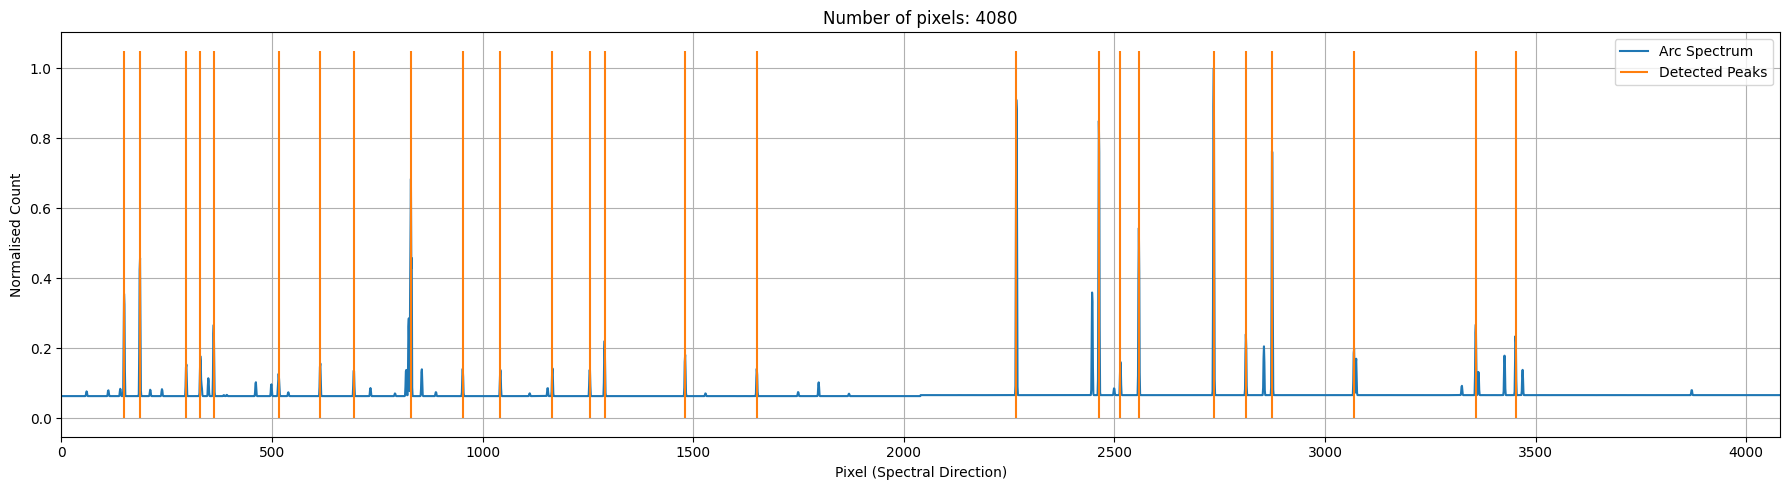

  0%|          | 0/5000 [00:00<?, ?it/s]

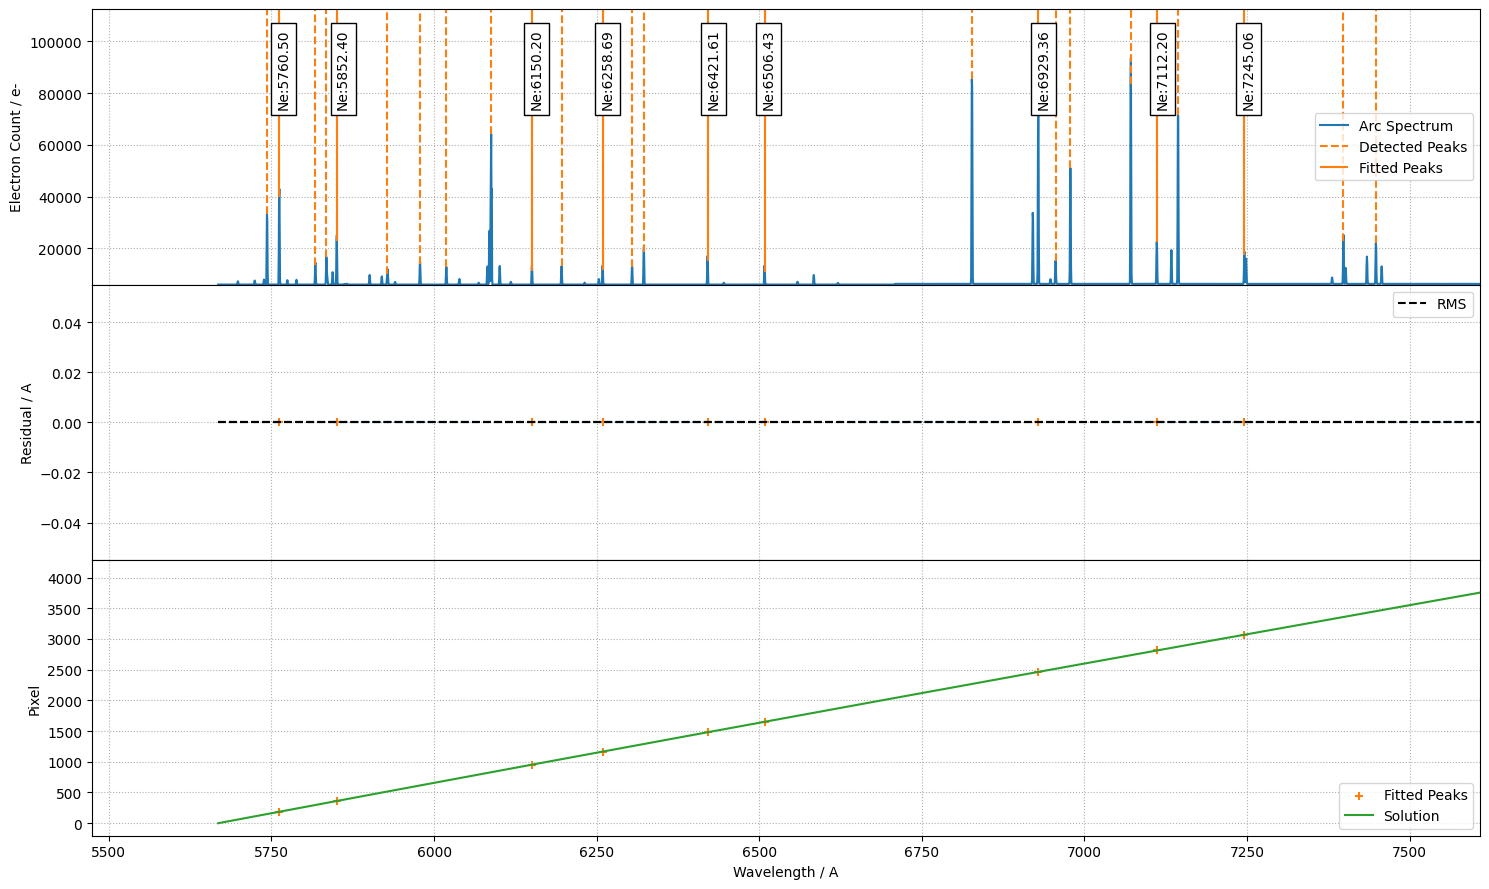

RMS: 1.1724437853392775
Stdev error: 0.5988880840742336 A
Peaks utilisation rate: 34.61538461538461%
Start measuring arc lines...


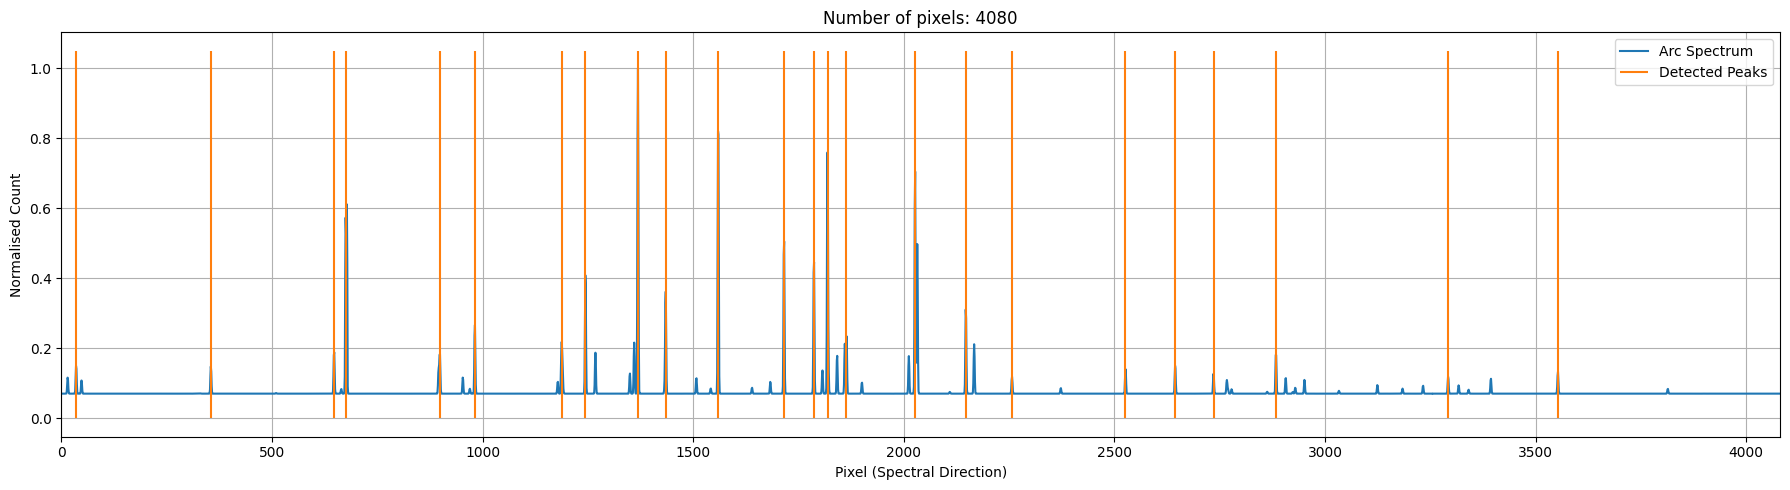

  0%|          | 0/5000 [00:00<?, ?it/s]

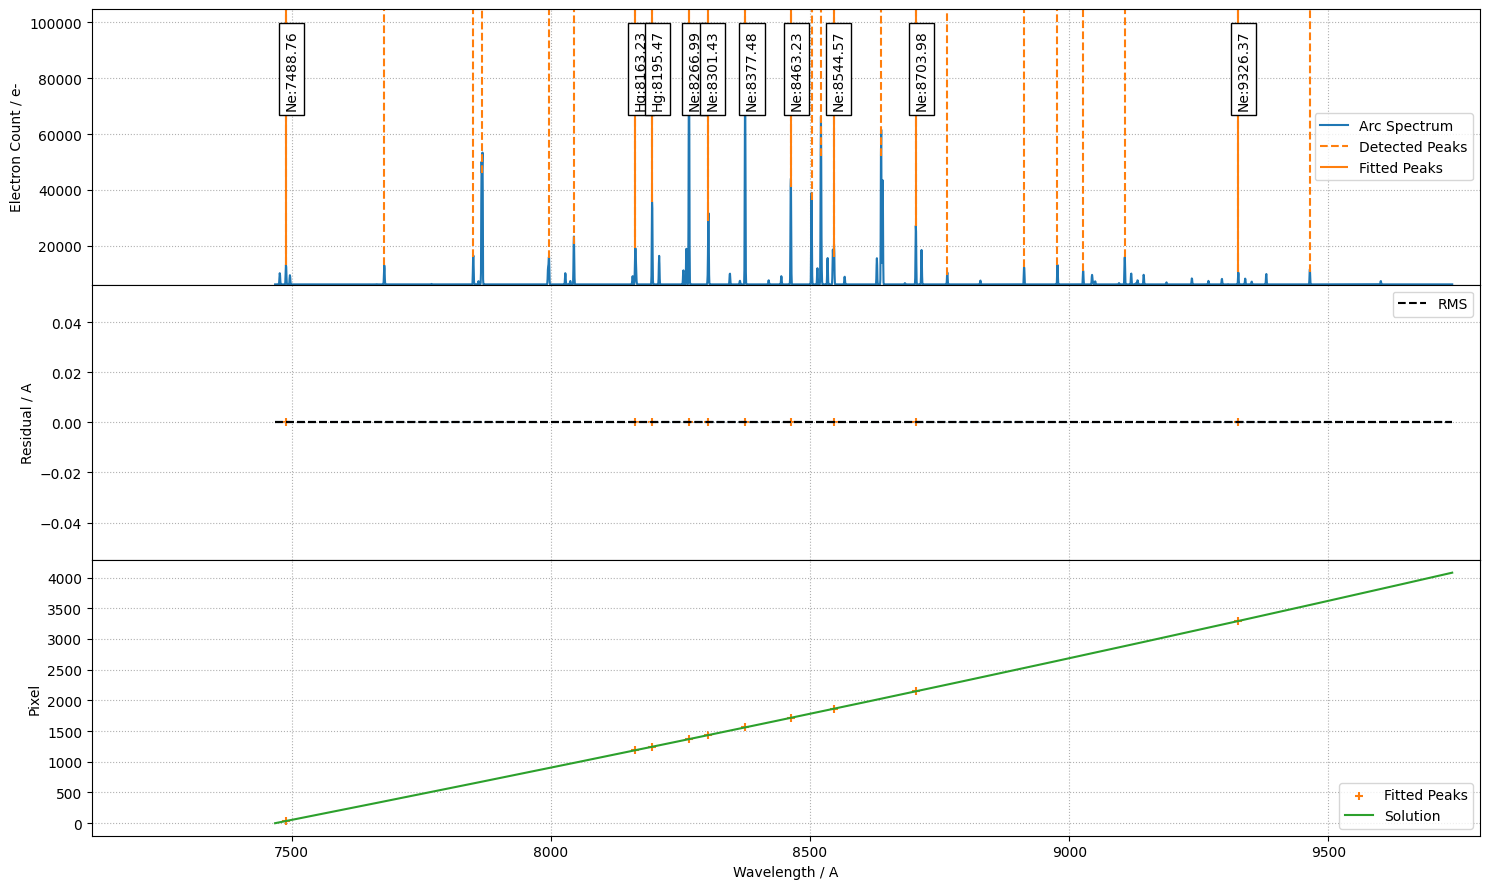

RMS: 1.2670037038068853
Stdev error: 0.9726868831328326 A
Peaks utilisation rate: 41.66666666666667%
Start measuring arc lines...


In [4]:


fiberflats = frames_groups[(unique_groups["imagetyp"]=="flat")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00001002")]
arcs = frames_groups[(unique_groups["imagetyp"]=="arc")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00010001")]

CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}

ised = 250
coad = 10

for fiberflat_frame, arc_frame in zip(fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    wave_range = CHANNEL_WL[arc_camera]

    imageMethod.extractSpec_drp(
        in_image=out_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_trace=out_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )

    # rssMethod.autoPixWaveMap_drp(
    #     in_arc=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
    #     out_pixwave=out_path.format(kind="pixwave", camera=arc_camera, expnum=arc_expnum, ext="txt"),
    #     elements="Ne,Hg", ref_fiber=ised, coadd_fibers=coad, wave_range=",".join(map(str, wave_range)),
    #     prominence=None, line_heights=10000, lines_dist=30, poly_deg=2, poly_kind="poly", plot=True
    # )

    rssMethod.detWaveSolution_drp(
        in_arc=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_wave=out_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_lsf=out_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_ref_lines=out_path.format(kind="pixwave", camera=arc_camera, expnum=arc_expnum, ext="txt"),
        ref_fiber=ised, poly_dispersion=-5, poly_fwhm='-5,1', verbose=1
    )

    rssMethod.createPixTable_drp(
        in_rss=out_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_wave=out_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_path.format(kind="harc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

Text(0.5, 1.0, "camera = 'z1'")

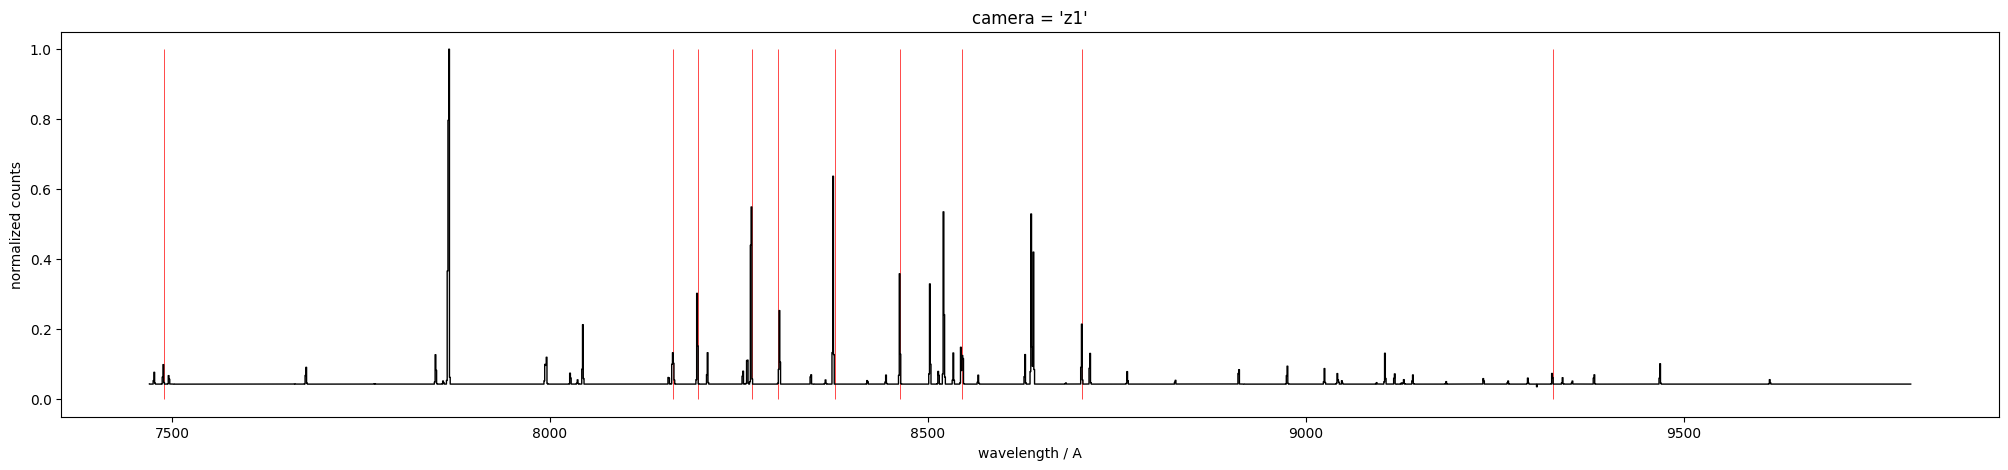

In [18]:
camera = "z1"
with open(out_path.format(kind="pixwave", camera=camera, expnum=arc_expnum, ext="txt")) as f:
    f.readline()
    _, lines_wav, _ = np.loadtxt(f, unpack=True)
    lines_int = np.ones_like(lines_wav)
    lines_min = np.zeros_like(lines_wav)

warc = rss.RSS()
warc.loadFitsData(out_path.format(kind="harc", camera=camera, expnum=arc_expnum, ext="fits"))

plt.figure(figsize=(25,5))
plt.vlines(lines_wav, lines_min, lines_int / lines_int, lw=0.5, ls="-", color="r")
plt.step(warc._wave, warc._data[ised]/np.nanmax(warc._data[ised]), color="k", lw=1)
plt.xlabel("wavelength / A")
plt.ylabel("normalized counts")
plt.title(f"{camera = }")

In [6]:
rssMethod.joinSpecChannels(
    in_rss=[out_path.format(kind="harc", camera=arc_frame["camera"], expnum=arc_frame["expnum"], ext="fits") for arc_frame in arcs],
    out_rss=out_path.format(kind="jarc", camera="sp1", expnum=arc_expnum, ext="fits"),
    parallel="auto"
)

Text(0, 0.5, 'normalized counts')

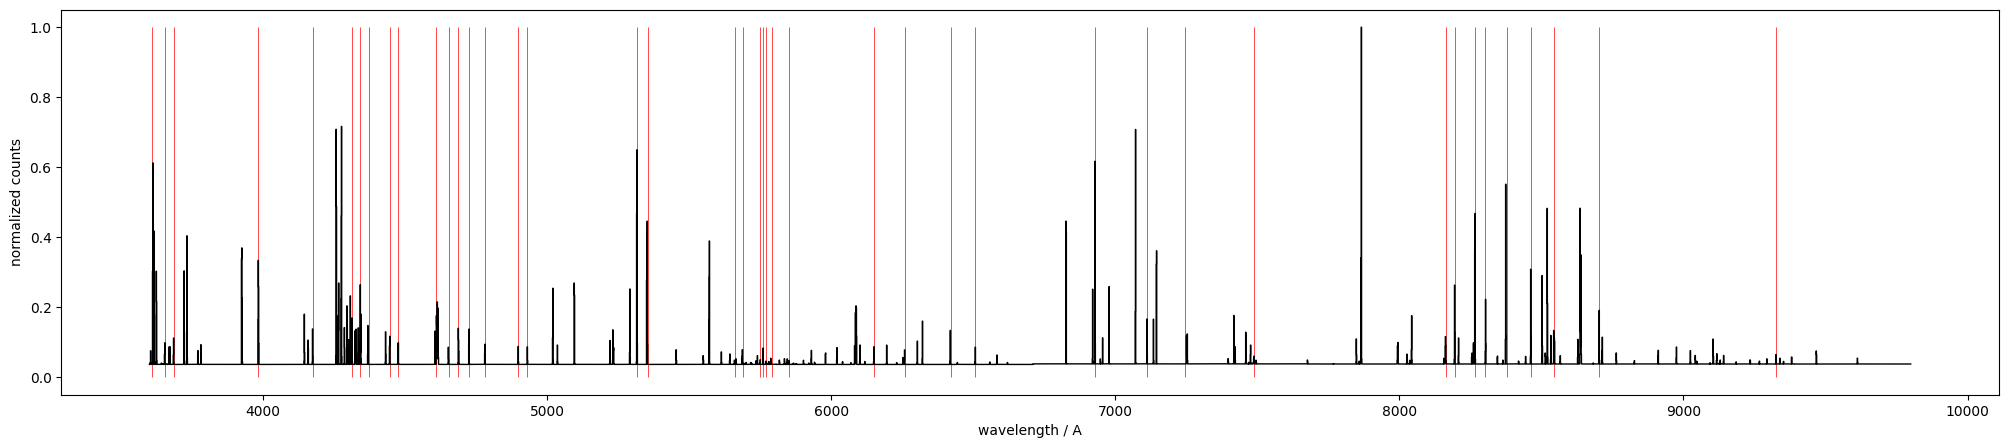

In [21]:
lines_all = []
for camera in CHANNEL_WL.keys():
    with open(out_path.format(kind="pixwave", camera=camera, expnum=arc_expnum, ext="txt")) as f:
        f.readline()
        _, lines_wav, _ = np.loadtxt(f, unpack=True)
    lines_all.append(lines_wav)
lines_wav = np.concatenate(lines_all)
lines_int = np.ones_like(lines_wav)
lines_min = np.zeros_like(lines_wav)

jarc = rss.RSS()
jarc.loadFitsData(out_path.format(kind="jarc", camera="sp1", expnum=arc_expnum, ext="fits"))

plt.figure(figsize=(25,5))
plt.vlines(lines_wav, lines_min, lines_int / lines_int, lw=0.5, ls="-", color="r")
plt.step(jarc._wave, jarc._data[300]/np.nanmax(jarc._data[300]), color="k", lw=1)
plt.xlabel("wavelength / A")
plt.ylabel("normalized counts")